In [1]:
import datetime
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix

In [2]:
train_data = pd.read_csv('weibo_train_data.txt', sep = '\t', encoding='utf-8', header = None, names = ['user_id', 'weibo_id', 'time', 'forward', 'comment', 'like', 'content'])

In [3]:
train_data.head()

,user_id,weibo_id,time,forward,comment,like,content
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,111多张


In [4]:
def parse_time(time_str):
    
    date = time_str[:10]
    time = time_str[11:]
    
    year, month, day = date.split('-')
    hour, minute, second = time.split(':')
    
    return [year, month, day, hour, minute, second]

In [5]:
def get_weekday(month, day):
    dt = datetime.datetime(2015, month, day)
    return dt.strftime('%w')

## Data Cleaning

In [6]:
df = train_data.copy()

In [7]:
df['time'] = df['time'].apply(parse_time)

In [8]:
train_data['year'] = df['time'].apply(lambda x : int(x[0]))
train_data['month'] = df['time'].apply(lambda x : int(x[1]))
train_data['day'] = df['time'].apply(lambda x : int(x[2]))
train_data['hour'] = df['time'].apply(lambda x : int(x[3]))
train_data['minute'] = df['time'].apply(lambda x : int(x[4]))
train_data['second'] = df['time'].apply(lambda x : int(x[5]))
train_data = train_data.drop(columns = ['time'])

In [9]:
train_data['weekday'] = train_data.apply(lambda x : int(get_weekday(x.month, x.day)), axis = 1)

In [10]:
train_data['length'] = train_data['content'].apply(lambda x : len(str(x)))

## EDA

In [11]:
data_summary = train_data.describe()

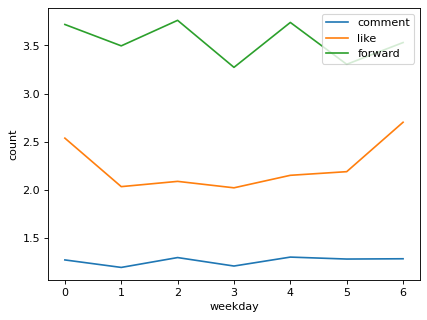

In [12]:
weekday_mean_like = [] 
weekday_mean_comment = [] 
weekday_mean_forward = [] 

for i in range(7):
    weekday_mean_like.append(train_data[train_data['weekday'] == i]['like'].mean())
    weekday_mean_comment.append(train_data[train_data['weekday'] == i]['comment'].mean())
    weekday_mean_forward.append(train_data[train_data['weekday'] == i]['forward'].mean())
    
figure(figsize=(6, 4.5), dpi=80)
plt.plot(weekday_mean_comment)
plt.plot(weekday_mean_like)
plt.plot(weekday_mean_forward)
plt.xlabel('weekday')
plt.ylabel('count')
plt.legend(['comment', 'like', 'forward'], loc = 1)
plt.show()

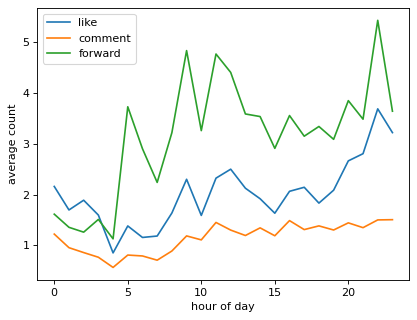

In [13]:
hour_mean_like = [] 
hour_mean_comment = [] 
hour_mean_forward = [] 

for i in range(24):
    hour_mean_like.append(train_data[train_data['hour'] == i]['like'].mean())
    hour_mean_comment.append(train_data[train_data['hour'] == i]['comment'].mean())
    hour_mean_forward.append(train_data[train_data['hour'] == i]['forward'].mean())

figure(figsize=(6, 4.5), dpi=80)
plt.plot(hour_mean_like)
plt.plot(hour_mean_comment)
plt.plot(hour_mean_forward)
plt.xlabel('hour of day')
plt.ylabel('average count')
plt.legend(['like', 'comment', 'forward'])
plt.show()

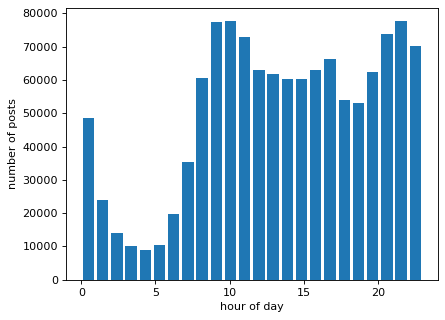

In [14]:
figure(figsize=(6, 4.5), dpi=80)
plt.hist(train_data['hour'],bins = 24,rwidth=0.8)
plt.xlabel('hour of day')
plt.ylabel('number of posts')
plt.show()

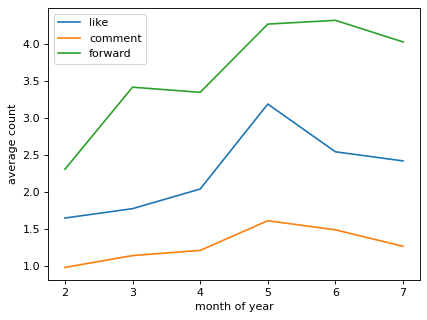

In [15]:
month_mean_like = [] 
month_mean_comment = [] 
month_mean_forward = [] 

for i in range(24):
    month_mean_like.append(train_data[train_data['month'] == i]['like'].mean())
    month_mean_comment.append(train_data[train_data['month'] == i]['comment'].mean())
    month_mean_forward.append(train_data[train_data['month'] == i]['forward'].mean())

figure(figsize=(6, 4.5), dpi=80)
plt.plot(month_mean_like)
plt.plot(month_mean_comment)
plt.plot(month_mean_forward)
plt.xlabel('month of year')
plt.ylabel('average count')
plt.legend(['like', 'comment', 'forward'])
plt.show()

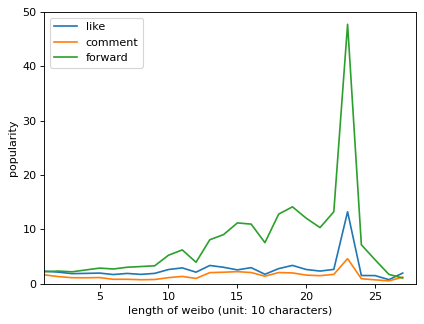

In [16]:
figure(figsize=(6, 4.5), dpi=80)

like_count = [[] for _ in range(28)]
comment_count = [[] for _ in range(28)]
forward_count = [[] for _ in range(28)]

for length,like,comment,forward in zip(train_data['length'],train_data['like'],train_data['comment'],train_data['forward']):
    if length > 280: 
        continue
    like_count[length//10-1].append(like)
    comment_count[length//10-1].append(comment)
    forward_count[length//10-1].append(forward)

out1 = [] 
out2 = [] 
out3 = []

for arr in like_count: 
    out1.append(np.mean(arr))
for arr in comment_count: 
    out2.append(np.mean(arr))
for arr in forward_count: 
    out3.append(np.mean(arr))
    
plt.plot(out1)
plt.plot(out2)
plt.plot(out3)
plt.ylim((0,50))
plt.xlim((1,28))
plt.xlabel('length of weibo (unit: 10 characters)')
plt.ylabel('popularity')
plt.legend(['like', 'comment', 'forward'],loc=2)
plt.show()
# cluster of popular weibo around length of 100 characters. Potentially quadratic relationship between length of weibo and popularity

In [17]:
def get_hashtag_count(parsed_text):
    count = 0
    for seg in str(parsed_text): 
        if seg == '##' or seg == '#': 
            count += 1 
    return count 

def get_mention_count(parsed_text):
    count = 0
    for seg in str(parsed_text): 
        if seg == '@': 
            count += 1 
    return count 

def content_segmentation(text): 
    seg_list = jieba.cut(str(text))
    return " ".join(seg_list)

In [18]:
train_data['parsed_text'] = train_data['content'].apply(content_segmentation)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\10841\AppData\Local\Temp\jieba.cache
Loading model cost 0.435 seconds.
Prefix dict has been built successfully.


In [19]:
train_data['parsed_text_str'] = train_data['parsed_text'].apply(lambda x : " ".join(x))

In [20]:
train_data['hashtag_count'] = train_data['content'].apply(get_hashtag_count)
train_data['mention_count'] = train_data['content'].apply(get_mention_count)

In [21]:
train_data.head()

,user_id,weibo_id,forward,comment,like,content,year,month,day,hour,minute,second,weekday,length,parsed_text,parsed_text_str,hashtag_count,mention_count
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,2015,2,23,17,41,29,1,62,丽江 旅游 ( sz002033 ) # 股票 ## 炒股 ## 财经 ## 理财 ## 投...,丽 江 旅 游 ( s z 0 0 2 0 3 3 ) # 股 票 ...,10,0
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,2015,2,14,12,49,58,6,100,# 丁辰灵 的 红包 # 挣钱 是 一种 能力 ， 抢红包 拼 的 是 技术 。 我 抢 到...,# 丁 辰 灵 的 红 包 # 挣 钱 是 一 种 能 力 ...,2,1
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了,2015,3,31,13,58,6,2,29,淘宝网 这些 傻 逼 。 。 。 气 的 劳资 有火 没 地儿 发 ~ 尼玛 ， 你们 都 瞎 了,淘 宝 网 这 些 傻 逼 。 。 。 气 的 劳 资 ...,0,0
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,0,4,3,看点不能说的，你们都懂[笑cry],2015,6,11,20,39,57,4,17,看点 不能 说 的 ， 你们 都 懂 [ 笑 cry ],看 点 不 能 说 的 ， 你 们 都 懂 [ 笑 ...,0,0
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,0,0,0,111多张,2015,3,10,18,2,38,2,5,111 多张,1 1 1 多 张,0,0


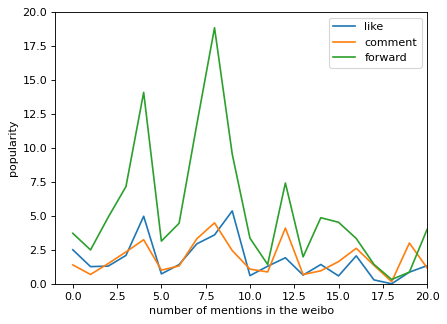

In [22]:
average_mention1 = [[] for _ in range(21)]
average_mention2 = [[] for _ in range(21)]
average_mention3 = [[] for _ in range(21)]
for count,like,comment,forward in zip(train_data['mention_count'],train_data['like'],train_data['comment'],train_data['forward']):
    if count < 21: 
        average_mention1[count].append(like)
        average_mention2[count].append(comment)
        average_mention3[count].append(forward)

temp1 = [] 
temp2 = [] 
temp3 = [] 

for arr1,arr2,arr3 in zip(average_mention1,average_mention2,average_mention3):
    temp1.append(np.mean(arr1))
    temp2.append(np.mean(arr2))
    temp3.append(np.mean(arr3))

figure(figsize=(6, 4.5), dpi=80)
plt.plot(temp1)
plt.plot(temp2)
plt.plot(temp3)
plt.xlabel('number of mentions in the weibo')
plt.ylabel('popularity')
plt.legend(['like', 'comment', 'forward'])
plt.xlim((-1,20))
plt.ylim((0,20))
plt.show()

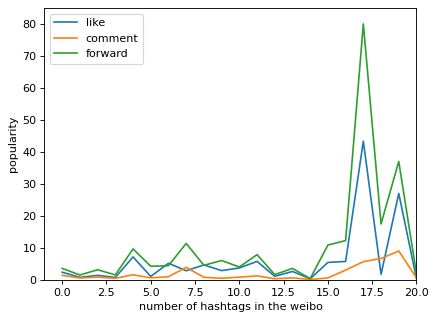

In [23]:
average_mention1 = [[] for _ in range(21)]
average_mention2 = [[] for _ in range(21)]
average_mention3 = [[] for _ in range(21)]
for count,like,comment,forward in zip(train_data['hashtag_count'],train_data['like'],train_data['comment'],train_data['forward']):
    if count < 21: 
        average_mention1[count].append(like)
        average_mention2[count].append(comment)
        average_mention3[count].append(forward)

temp1 = [] 
temp2 = [] 
temp3 = [] 

for arr1,arr2,arr3 in zip(average_mention1,average_mention2,average_mention3):
    temp1.append(np.mean(arr1))
    temp2.append(np.mean(arr2))
    temp3.append(np.mean(arr3))

figure(figsize=(6, 4.5), dpi=80)
plt.plot(temp1)
plt.plot(temp2)
plt.plot(temp3)
plt.xlabel('number of hashtags in the weibo')
plt.ylabel('popularity')
plt.legend(['like', 'comment', 'forward'])
plt.xlim((-1,20))
plt.ylim((0,85))
plt.show()

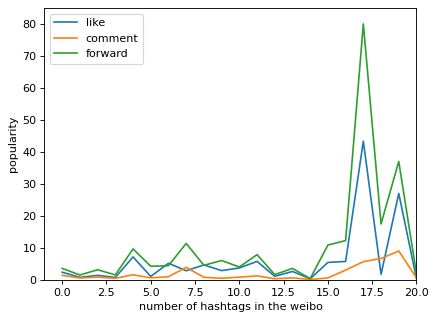

In [24]:
average_mention1 = [[] for _ in range(21)]
average_mention2 = [[] for _ in range(21)]
average_mention3 = [[] for _ in range(21)]
for count,like,comment,forward in zip(train_data['hashtag_count'],train_data['like'],train_data['comment'],train_data['forward']):
    if count < 21: 
        average_mention1[count].append(like)
        average_mention2[count].append(comment)
        average_mention3[count].append(forward)

temp1 = [] 
temp2 = [] 
temp3 = [] 

for arr1,arr2,arr3 in zip(average_mention1,average_mention2,average_mention3):
    temp1.append(np.mean(arr1))
    temp2.append(np.mean(arr2))
    temp3.append(np.mean(arr3))

figure(figsize=(6, 4.5), dpi=80)
plt.plot(temp1)
plt.plot(temp2)
plt.plot(temp3)
plt.xlabel('number of hashtags in the weibo')
plt.ylabel('popularity')
plt.legend(['like', 'comment', 'forward'])
plt.xlim((-1,20))
plt.ylim((0,85))
plt.show()

In [25]:
vectorizer = CountVectorizer(max_features = 1000)
X = vectorizer.fit_transform(train_data['parsed_text'])
BoW_feature = pd.DataFrame(csr_matrix.toarray(X))

In [35]:
vectorizer = TfidfVectorizer(max_features = 1000)
X = vectorizer.fit_transform(train_data['parsed_text'])
BoW_feature = pd.DataFrame(csr_matrix.toarray(X))

In [36]:
new_feat = pd.concat([BoW_feature,train_data[['hour','weekday','length','hashtag_count','mention_count']]],axis = 1)

In [28]:
new_feat.shape

(1225088, 1005)

In [29]:
# BoW_feature = BoW_feature.append(train_data[['hour','weekday','length','hashtag_count','mention_count']])

In [30]:
train_data['popularity'] = train_data['like'] + train_data['comment'] + train_data['forward']

In [37]:
reg = LinearRegression(n_jobs = -1)
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','explained_variance']
scores = cross_validate(reg, new_feat, train_data['popularity'], scoring=scoring)
scores

{'fit_time': array([74.38714838, 69.73067737, 70.21310306, 62.97364688, 67.17050481]),
 'score_time': array([0.91928959, 1.24181867, 1.27044034, 1.30729151, 1.20647621]),
 'test_neg_mean_squared_error': array([-15301.86309667,  -8380.7133635 , -18008.37873521, -25059.62941967,
        -12288.67380702]),
 'test_neg_mean_absolute_error': array([-13.65237669, -13.90057158, -13.88055399, -14.03906221,
        -13.86316908]),
 'test_explained_variance': array([0.02556711, 0.02247459, 0.02702013, 0.01008979, 0.0278032 ])}

In [38]:
reg = Ridge(alpha = 1)
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','explained_variance']
scores = cross_validate(reg, new_feat, train_data['popularity'], scoring=scoring)
scores

{'fit_time': array([36.16219735, 28.9847405 , 26.86359811, 26.83116889, 35.11844397]),
 'score_time': array([1.20927024, 1.23427629, 1.27628493, 1.23280597, 0.86666417]),
 'test_neg_mean_squared_error': array([-15301.91903947,  -8380.34229788, -18008.6181117 , -25059.39696665,
        -12288.5968149 ]),
 'test_neg_mean_absolute_error': array([-13.64280183, -13.88987577, -13.87146965, -14.02895336,
        -13.85315328]),
 'test_explained_variance': array([0.02556355, 0.02251787, 0.0270072 , 0.01009897, 0.02780929])}

In [39]:
reg = Lasso(alpha = 0.1)
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','explained_variance']
scores = cross_validate(reg, new_feat, train_data['popularity'], scoring=scoring)
scores

{'fit_time': array([43.66199183, 37.88025951, 53.93727589, 46.24083066, 46.20578289]),
 'score_time': array([2.24711227, 2.19949079, 2.19736266, 2.270509  , 2.25750613]),
 'test_neg_mean_squared_error': array([-15534.11569543,  -8452.30363966, -18332.98249456, -25169.5881207 ,
        -12480.5140111 ]),
 'test_neg_mean_absolute_error': array([-11.08825748, -10.92373526, -11.49979519, -11.2139978 ,
        -11.19068342]),
 'test_explained_variance': array([0.01077763, 0.01412139, 0.0094853 , 0.00574616, 0.01262616])}

In [34]:
train_data.head()

,user_id,weibo_id,forward,comment,like,content,year,month,day,hour,minute,second,weekday,length,parsed_text,parsed_text_str,hashtag_count,mention_count,popularity
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,2015,2,23,17,41,29,1,62,丽江 旅游 ( sz002033 ) # 股票 ## 炒股 ## 财经 ## 理财 ## 投...,丽 江 旅 游 ( s z 0 0 2 0 3 3 ) # 股 票 ...,10,0,0
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,2015,2,14,12,49,58,6,100,# 丁辰灵 的 红包 # 挣钱 是 一种 能力 ， 抢红包 拼 的 是 技术 。 我 抢 到...,# 丁 辰 灵 的 红 包 # 挣 钱 是 一 种 能 力 ...,2,1,0
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了,2015,3,31,13,58,6,2,29,淘宝网 这些 傻 逼 。 。 。 气 的 劳资 有火 没 地儿 发 ~ 尼玛 ， 你们 都 瞎 了,淘 宝 网 这 些 傻 逼 。 。 。 气 的 劳 资 ...,0,0,0
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,0,4,3,看点不能说的，你们都懂[笑cry],2015,6,11,20,39,57,4,17,看点 不能 说 的 ， 你们 都 懂 [ 笑 cry ],看 点 不 能 说 的 ， 你 们 都 懂 [ 笑 ...,0,0,7
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,0,0,0,111多张,2015,3,10,18,2,38,2,5,111 多张,1 1 1 多 张,0,0,0
